# Introduction to Geospatial Data Analysis 2024 - 2025
## Final Mini Project - Due: April 16
### Isil Oral & Tatyana Yakushina

* Project on green gentrification in Vienna through social status index, green spaces, blue areas, and housing prices 

*set up for the analysis*

In [1]:
from shapely.geometry import Point, LineString, Polygon, MultiPolygon
from shapely.geometry import box
import geopandas as gpd
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import rasterio
from rasterio.mask import mask
from rasterio.plot import show
from rasterio.warp import calculate_default_transform, reproject
from rasterio.enums import Resampling
import osmnx as ox  
import contextily as ctx
from geopy.geocoders import Nominatim  
from geopy.extra.rate_limiter import RateLimiter

### Urban green spaces data 
Data is from 'Open Data Austria', obtained through *Riepl et. al (2025)*

In [2]:
file_name = 'OEFFGRUENFLOGD.json'
gdf_green = gpd.read_file(file_name)
gdf_green.head(3)

,id,OBJECTID,TEXT13ID,F_TYP,T_TEXT,T_LANG,O,P,O_UEREG,O_REGION,...,Q_GRI,Q_HUN,Q_BAB,Q_WC,Q_SPO,Q_TRB,UMFANG,FLAECHE,SE_ANNO_CAD_DATA,geometry
0,OEFFGRUENFLOGD.2289,2289,Währinger Pa*,L,Währinger Park,Währinger Park,1,100000,0,0,...,0,1,0,1,1245,1,1460.941451,57020.131903,None,"MULTIPOLYGON (((16.35083 48.23369, 16.34929 48..."
1,OEFFGRUENFLOGD.2290,2290,Türkenschanz*,L,Türkenschanzplatz,Türkenschanzplatz,1,1,0,0,...,0,0,0,0,0,0,310.900196,2002.715993,None,"POLYGON ((16.32886 48.23482, 16.32824 48.23492..."
2,OEFFGRUENFLOGD.2291,2291,Kongreßpark,L,Kongreßpark/Kainzga,Kainzgasse,1,100000,0,0,...,0,1,0,2,12,1,249.284876,3243.484789,None,"POLYGON ((16.30871 48.22281, 16.30933 48.22285..."


In [3]:
print(gdf_green.columns)

Index(['id', 'OBJECTID', 'TEXT13ID', 'F_TYP', 'T_TEXT', 'T_LANG', 'O', 'P',
       'O_UEREG', 'O_REGION', 'O_LOKAL', 'P_WLD', 'P_WAS', 'P_WIE', 'P_WGT',
       'P_LW', 'P_PK', 'P_GPK', 'P_GST', 'P_SGR', 'P_AGR', 'P_RGR', 'P_URB',
       'Q_MOB', 'Q_SPI', 'Q_GRI', 'Q_HUN', 'Q_BAB', 'Q_WC', 'Q_SPO', 'Q_TRB',
       'UMFANG', 'FLAECHE', 'SE_ANNO_CAD_DATA', 'geometry'],
      dtype='object')


In [4]:
# to learn whether there is metadata, if yes what columns mean
!pip install fiona
import fiona

In [5]:
with fiona.open(file_name) as src:
    #print(src.schema)  # Gives field names and types
    print(src.meta)    # Sometimes includes more metadata

{'driver': 'GeoJSON', 'schema': {'properties': {'id': 'str', 'OBJECTID': 'int32', 'TEXT13ID': 'str', 'F_TYP': 'str', 'T_TEXT': 'str', 'T_LANG': 'str', 'O': 'int32', 'P': 'int', 'O_UEREG': 'int32', 'O_REGION': 'int32', 'O_LOKAL': 'int32', 'P_WLD': 'int32', 'P_WAS': 'int32', 'P_WIE': 'int32', 'P_WGT': 'int32', 'P_LW': 'int32', 'P_PK': 'int32', 'P_GPK': 'int32', 'P_GST': 'int32', 'P_SGR': 'int32', 'P_AGR': 'int32', 'P_RGR': 'int32', 'P_URB': 'int32', 'Q_MOB': 'int32', 'Q_SPI': 'int32', 'Q_GRI': 'int32', 'Q_HUN': 'int32', 'Q_BAB': 'int32', 'Q_WC': 'int32', 'Q_SPO': 'int32', 'Q_TRB': 'int32', 'UMFANG': 'float', 'FLAECHE': 'float', 'SE_ANNO_CAD_DATA': 'str'}, 'geometry': 'Unknown'}, 'crs': CRS.from_epsg(4326), 'crs_wkt': 'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAS

### Some social and economic data for each census district of Vienna
Data is from 'Open Data Austria', obtained through *Riepl et. al (2025)*

In [6]:
gdf_census = gpd.read_file('data_ssi.geojson')
gdf_census

,ZBEZ,university_share,avg_income,unemprate,benefit_share,SSI,quintile,geometry
0,0101,1.604954,1.741399,1.125923,1.123008,1.653992,5,"POLYGON ((16.37903 48.21187, 16.37902 48.21188..."
1,0102,1.653812,2.565233,1.237000,1.139440,2.000434,5,"POLYGON ((16.37906 48.20748, 16.37882 48.20755..."
2,0103,1.706598,3.805033,1.641029,1.232519,2.570582,5,"POLYGON ((16.36893 48.20072, 16.36905 48.20072..."
3,0104,1.845975,3.156000,1.697713,1.313290,2.407460,5,"POLYGON ((16.36326 48.2039, 16.36383 48.20424,..."
4,0105,1.681303,2.424953,1.192502,1.252134,1.971322,5,"POLYGON ((16.36765 48.21307, 16.36843 48.21273..."
...,...,...,...,...,...,...,...,...
241,2315,1.267620,2.076986,1.032159,0.955199,1.604961,5,"POLYGON ((16.26417 48.15314, 16.26433 48.1532,..."
242,2316,-0.038446,0.315260,0.839466,0.834993,0.412143,4,"POLYGON ((16.23894 48.15341, 16.23821 48.15312..."
243,2317,-0.410833,0.503589,0.921774,1.088109,0.406096,4,"POLYGON ((16.37712 48.14752, 16.37708 48.14753..."
244,2318,-1.138054,-0.177753,-0.123182,0.210761,-0.470587,2,"POLYGON ((16.34062 48.1487, 16.34051 48.14871,..."


In [7]:
with fiona.open('data_ssi.geojson') as src:
    #sprint(src.schema)  # Gives field names and types
    print(src.meta)    # Sometimes includes more metadata

{'driver': 'GeoJSON', 'schema': {'properties': {'ZBEZ': 'str', 'university_share': 'float', 'avg_income': 'float', 'unemprate': 'float', 'benefit_share': 'float', 'SSI': 'float', 'quintile': 'int32'}, 'geometry': 'Polygon'}, 'crs': CRS.from_epsg(4326), 'crs_wkt': 'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'}


### Data for blue spaces and administrative boundaries
Data is from OpenStreetMap

<Axes: >

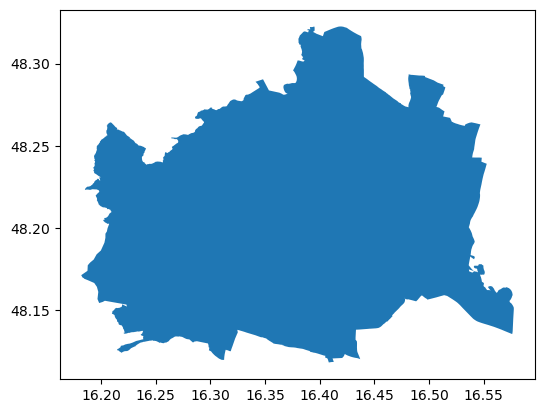

In [8]:
admin_city = ox.geocode_to_gdf('Vienna')
admin_city.plot()

In [9]:
# Define the polygon for the administrative 
admin_poly = admin_city.geometry.values[0]

# COMMENT: CHECK FOR FURTHER BLUE SPACES
# Download POIs for blue spaces within the administrative boundary
blue = ox.features_from_polygon(admin_poly, tags={'natural': 'water', 'water': 'river', 'water': 'canal', 'waterway': 'ditch', 'water': 'pond', 'water': 'reservoir', 'water': 'basin', 'water': 'lake'})

print("Water sources:", len(blue))
print("Type of data:", type(blue))
blue.head(3)

Water sources: 873
Type of data: <class 'geopandas.geodataframe.GeoDataFrame'>


geometry waterway  \
element  id                                                                  
relation 75     POLYGON ((16.42474 48.22954, 16.42471 48.22955...      NaN   
         18443  POLYGON ((16.5844 48.1324, 16.58205 48.13265, ...      NaN   
         18444  POLYGON ((16.38583 48.25149, 16.38573 48.25156...      NaN   

               wikidata               name natural source  water boat barrier  \
element  id                                                                     
relation 75         NaN  Untere Alte Donau   water    NaN  oxbow  NaN     NaN   
         18443      NaN                NaN   water    NaN  river  NaN     NaN   
         18444  Q877785         Neue Donau   water    NaN  river  NaN     NaN   

               depth  ...          type odbl attraction name:cs name:hr  \
element  id           ...                                                 
relation 75      NaN  ...  multipolygon  NaN        NaN     NaN     NaN   
         18443   NaN  ...  multipolygon  NaN        NaN     NaN     NaN   
         18444   NaN  ...  multipolygon  NaN        NaN     NaN     NaN   

               name:hu name:sh name:sk name:sr species:wikidata  
element  id                                                      
relation 75        NaN     NaN     NaN     NaN              NaN  
         18443     NaN     NaN     NaN     NaN              NaN  
         18444     NaN     NaN     NaN     NaN              NaN  

[3 rows x 92 columns]

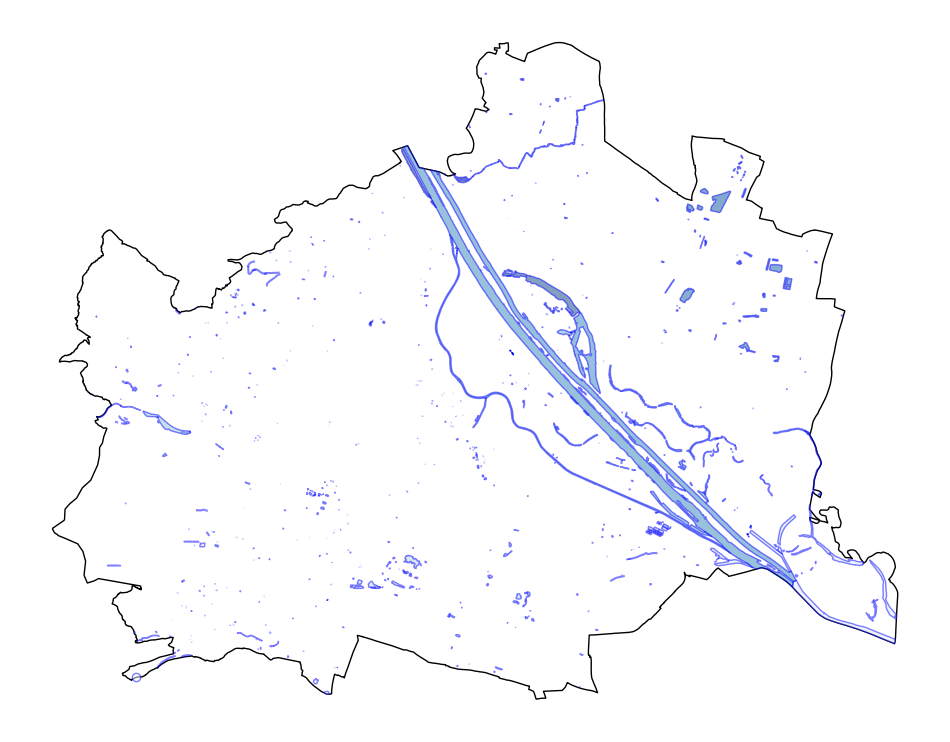

In [10]:
blue_clipped = gpd.clip(blue, admin_city)

# Create a plot to visualize the admin boundary and blue spaces
f, ax = plt.subplots(1, 1, figsize=(12, 12))

# Plot the administrative boundary
admin_city.plot(ax=ax, color='none', edgecolor='k')

# Plot the parks
blue_clipped.plot(ax=ax, cmap='Blues', alpha=0.5, edgecolor='blue')

# Customize the plot
ax.axis('off')
plt.show()

### Further green space data
from OSM

In [11]:
'''
greens = ox.features_from_polygon(admin_poly, tags={'leisure': 'nature_reserve', 'leisure': 'garden', 'leisure': 'park', 'amenity': 'graveyard', 'landuse': 'cemetery', 'landuse': 'recreation_ground', 'landuse': 'forest'})

print("Green spaces:", len(greens))
print("Type of data:", type(greens))
greens.head()
'''

'\ngreens = ox.features_from_polygon(admin_poly, tags={\'leisure\': \'nature_reserve\', \'leisure\': \'garden\', \'leisure\': \'park\', \'amenity\': \'graveyard\', \'landuse\': \'cemetery\', \'landuse\': \'recreation_ground\', \'landuse\': \'forest\'})\n\nprint("Green spaces:", len(greens))\nprint("Type of data:", type(greens))\ngreens.head()\n'

In [12]:
'''
# Create a plot to visualize the admin boundary and green spaces
f, ax = plt.subplots(1, 1, figsize=(12, 12))

# Plot the administrative boundary
admin_city.plot(ax=ax, color='none', edgecolor='k')

# Plot the parks
greens.plot(ax=ax, cmap='Greens', alpha=0.5, edgecolor='darkgreen')

# Customize the plot
ax.axis('off')
plt.show()
'''

"\n# Create a plot to visualize the admin boundary and green spaces\nf, ax = plt.subplots(1, 1, figsize=(12, 12))\n\n# Plot the administrative boundary\nadmin_city.plot(ax=ax, color='none', edgecolor='k')\n\n# Plot the parks\ngreens.plot(ax=ax, cmap='Greens', alpha=0.5, edgecolor='darkgreen')\n\n# Customize the plot\nax.axis('off')\nplt.show()\n"

In [13]:
'''
# both greens and blues by using OSM:
# to show the overlap of green and blue spaces in Vienna
f, ax = plt.subplots(1, 1, figsize=(12, 12))

# Plot the administrative boundary
admin_city.plot(ax=ax, color='none', edgecolor='k')

# Plot the parks
greens.plot(ax=ax, cmap='Greens', alpha=0.5, edgecolor='darkgreen')
blue_clipped.plot(ax=ax, cmap='Blues', alpha=0.5, edgecolor='blue')

# Customize the plot
ax.axis('off')
plt.show()
'''

"\n# both greens and blues by using OSM:\n# to show the overlap of green and blue spaces in Vienna\nf, ax = plt.subplots(1, 1, figsize=(12, 12))\n\n# Plot the administrative boundary\nadmin_city.plot(ax=ax, color='none', edgecolor='k')\n\n# Plot the parks\ngreens.plot(ax=ax, cmap='Greens', alpha=0.5, edgecolor='darkgreen')\nblue_clipped.plot(ax=ax, cmap='Blues', alpha=0.5, edgecolor='blue')\n\n# Customize the plot\nax.axis('off')\nplt.show()\n"

## Visualizations

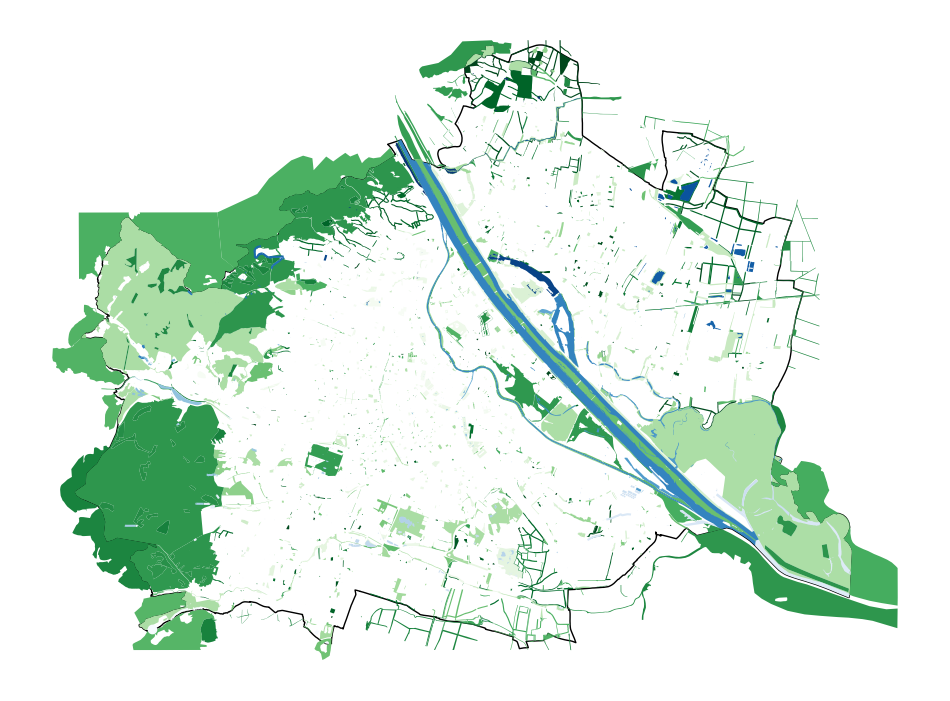

In [14]:
#greens from Open Data Austria, and blues from OSM:

f, ax = plt.subplots(1, 1, figsize=(12, 12))

admin_city.plot(ax=ax, color='none', edgecolor='k')
gdf_green.plot(ax=ax, cmap='Greens')
blue_clipped.plot(ax=ax, cmap='Blues')
ax.axis('off')

plt.savefig("vienna_green_blue_map.png", dpi=300, bbox_inches='tight')
plt.show()

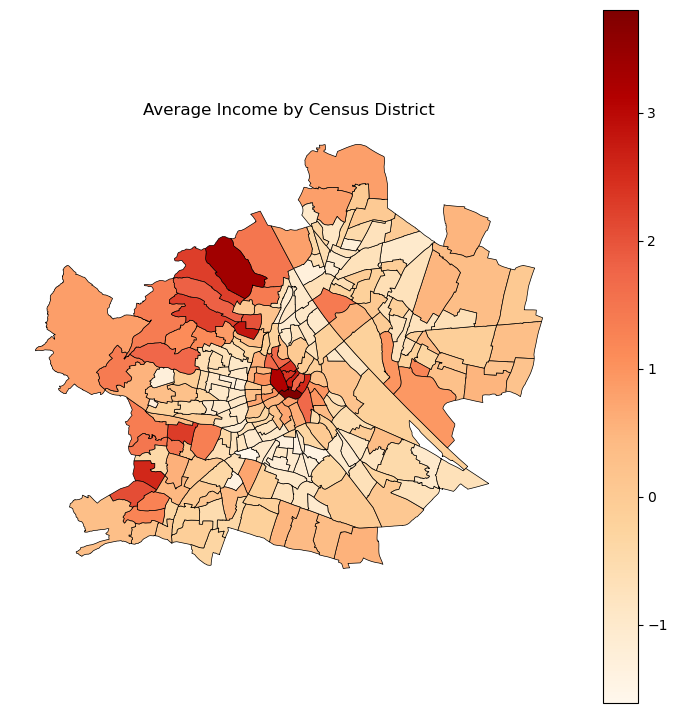

In [15]:
# Plot average income by census district
fig, ax = plt.subplots(1, 1, figsize=(9, 9))

gdf_census.plot(
    column='avg_income',     
    cmap='OrRd',              
    linewidth=0.5,            
    edgecolor='black',        
    legend=True,              
    ax=ax
)

ax.set_title("Average Income by Census District", fontsize=12)
ax.axis('off')

plt.savefig("avg_income_map.png", dpi=300, bbox_inches='tight')
plt.show()

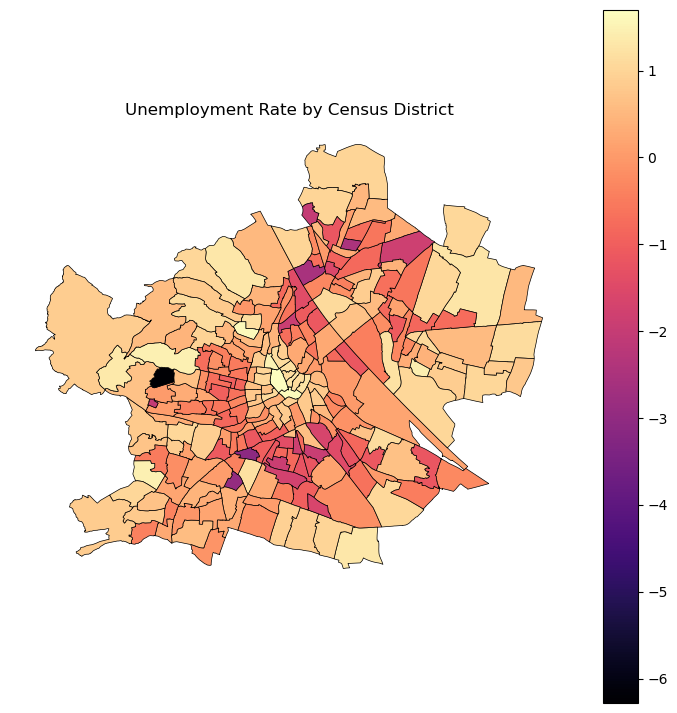

In [16]:
# Plot average income by census district
fig, ax = plt.subplots(1, 1, figsize=(9, 9))

gdf_census.plot(
    column='unemprate',      
    cmap='magma',              
    linewidth=0.5,            
    edgecolor='black',        
    legend=True,              
    ax=ax
)

ax.set_title("Unemployment Rate by Census District", fontsize=12)
ax.axis('off')

plt.savefig("unemp_rate_map.png", dpi=300, bbox_inches='tight')
plt.show()

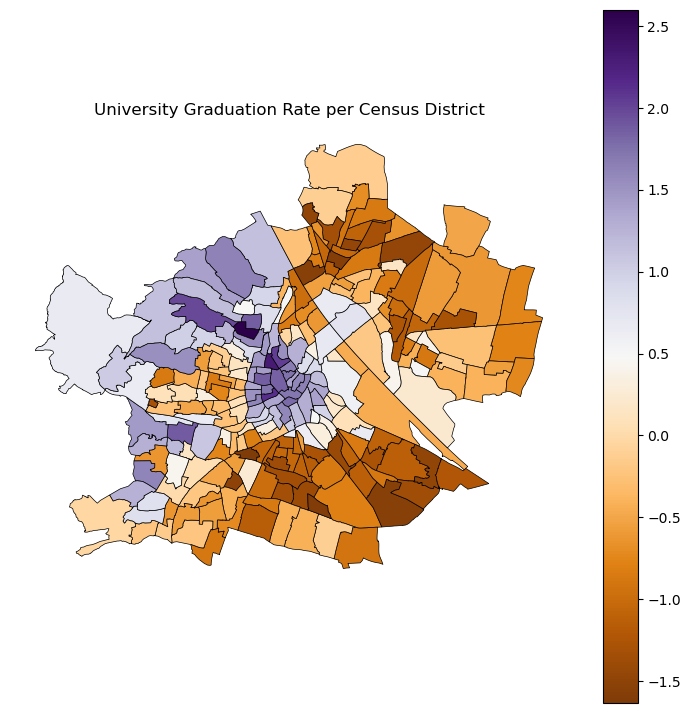

In [17]:
# Plot average income by census district
fig, ax = plt.subplots(1, 1, figsize=(9, 9))

gdf_census.plot(
    column='university_share',     
    cmap='PuOr',              
    linewidth=0.5,            
    edgecolor='black',        
    legend=True,             
    ax=ax
)

ax.set_title("University Graduation Rate per Census District", fontsize=12)
ax.axis('off')

plt.savefig("uni_grad_rate_map.png", dpi=300, bbox_inches='tight')
plt.show()

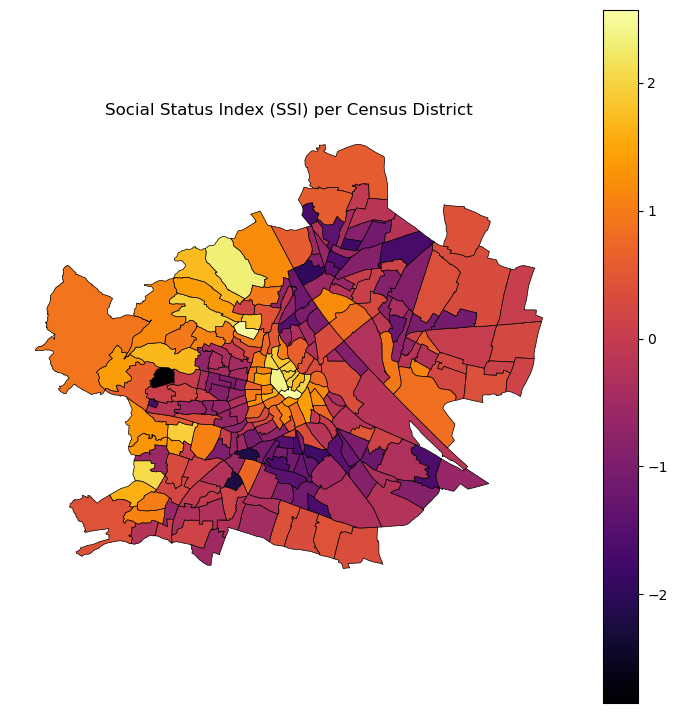

In [18]:
# Plot SSI by census district
fig, ax = plt.subplots(1, 1, figsize=(9, 9))

gdf_census.plot(
    column='SSI',      
    cmap='inferno',              
    linewidth=0.5,           
    edgecolor='black',        
    legend=True,              
    ax=ax
)

ax.set_title("Social Status Index (SSI) per Census District", fontsize=12)
ax.axis('off')

plt.savefig("ssi_map.png", dpi=300, bbox_inches='tight')
plt.show()

In [19]:
'''
# run 4 codes above as a loop instead of running several times

# Variables and settings to loop through
plot_settings = [
    {'column': 'SSI', 'title': 'Social Status Index (SSI)', 'cmap': 'inferno', 'file': 'ssi_map.png'},
    {'column': 'avg_income', 'title': 'Average Income', 'cmap': 'OrRd', 'file': 'avg_income_map.png'},
    {'column': 'university_share', 'title': 'University Graduate Share', 'cmap': 'Greens', 'file': 'university_share_map.png'},
    {'column': 'unemprate', 'title': 'Unemployment Rate', 'cmap': 'Blues', 'file': 'unemployment_map.png'},
]

for setting in plot_settings:
    fig, ax = plt.subplots(figsize=(9, 9))
    
    # Plot without built-in legend
    gdf_census.plot(
        column=setting['column'],
        cmap=setting['cmap'],
        linewidth=0.5,
        edgecolor='black',
        legend=False,
        ax=ax
    )

    # Custom colorbar
    norm = mpl.colors.Normalize(
        vmin=gdf_census[setting['column']].min(),
        vmax=gdf_census[setting['column']].max()
    )
    sm = mpl.cm.ScalarMappable(norm=norm, cmap=setting['cmap'])
    sm._A = []
    
    cbar = fig.colorbar(sm, ax=ax, shrink=0.5, pad=0.01)
    ax.set_title(f"{setting['title']} per Census District", fontsize=12)
    ax.axis('off')
    
    plt.savefig(setting['file'], dpi=300, bbox_inches='tight')
    plt.close()  # close the figure to free memory
'''

'\n# run 4 codes above as a loop instead of running several times\n\n# Variables and settings to loop through\nplot_settings = [\n    {\'column\': \'SSI\', \'title\': \'Social Status Index (SSI)\', \'cmap\': \'inferno\', \'file\': \'ssi_map.png\'},\n    {\'column\': \'avg_income\', \'title\': \'Average Income\', \'cmap\': \'OrRd\', \'file\': \'avg_income_map.png\'},\n    {\'column\': \'university_share\', \'title\': \'University Graduate Share\', \'cmap\': \'Greens\', \'file\': \'university_share_map.png\'},\n    {\'column\': \'unemprate\', \'title\': \'Unemployment Rate\', \'cmap\': \'Blues\', \'file\': \'unemployment_map.png\'},\n]\n\nfor setting in plot_settings:\n    fig, ax = plt.subplots(figsize=(9, 9))\n\n    # Plot without built-in legend\n    gdf_census.plot(\n        column=setting[\'column\'],\n        cmap=setting[\'cmap\'],\n        linewidth=0.5,\n        edgecolor=\'black\',\n        legend=False,\n        ax=ax\n    )\n\n    # Custom colorbar\n    norm = mpl.colors.Norm

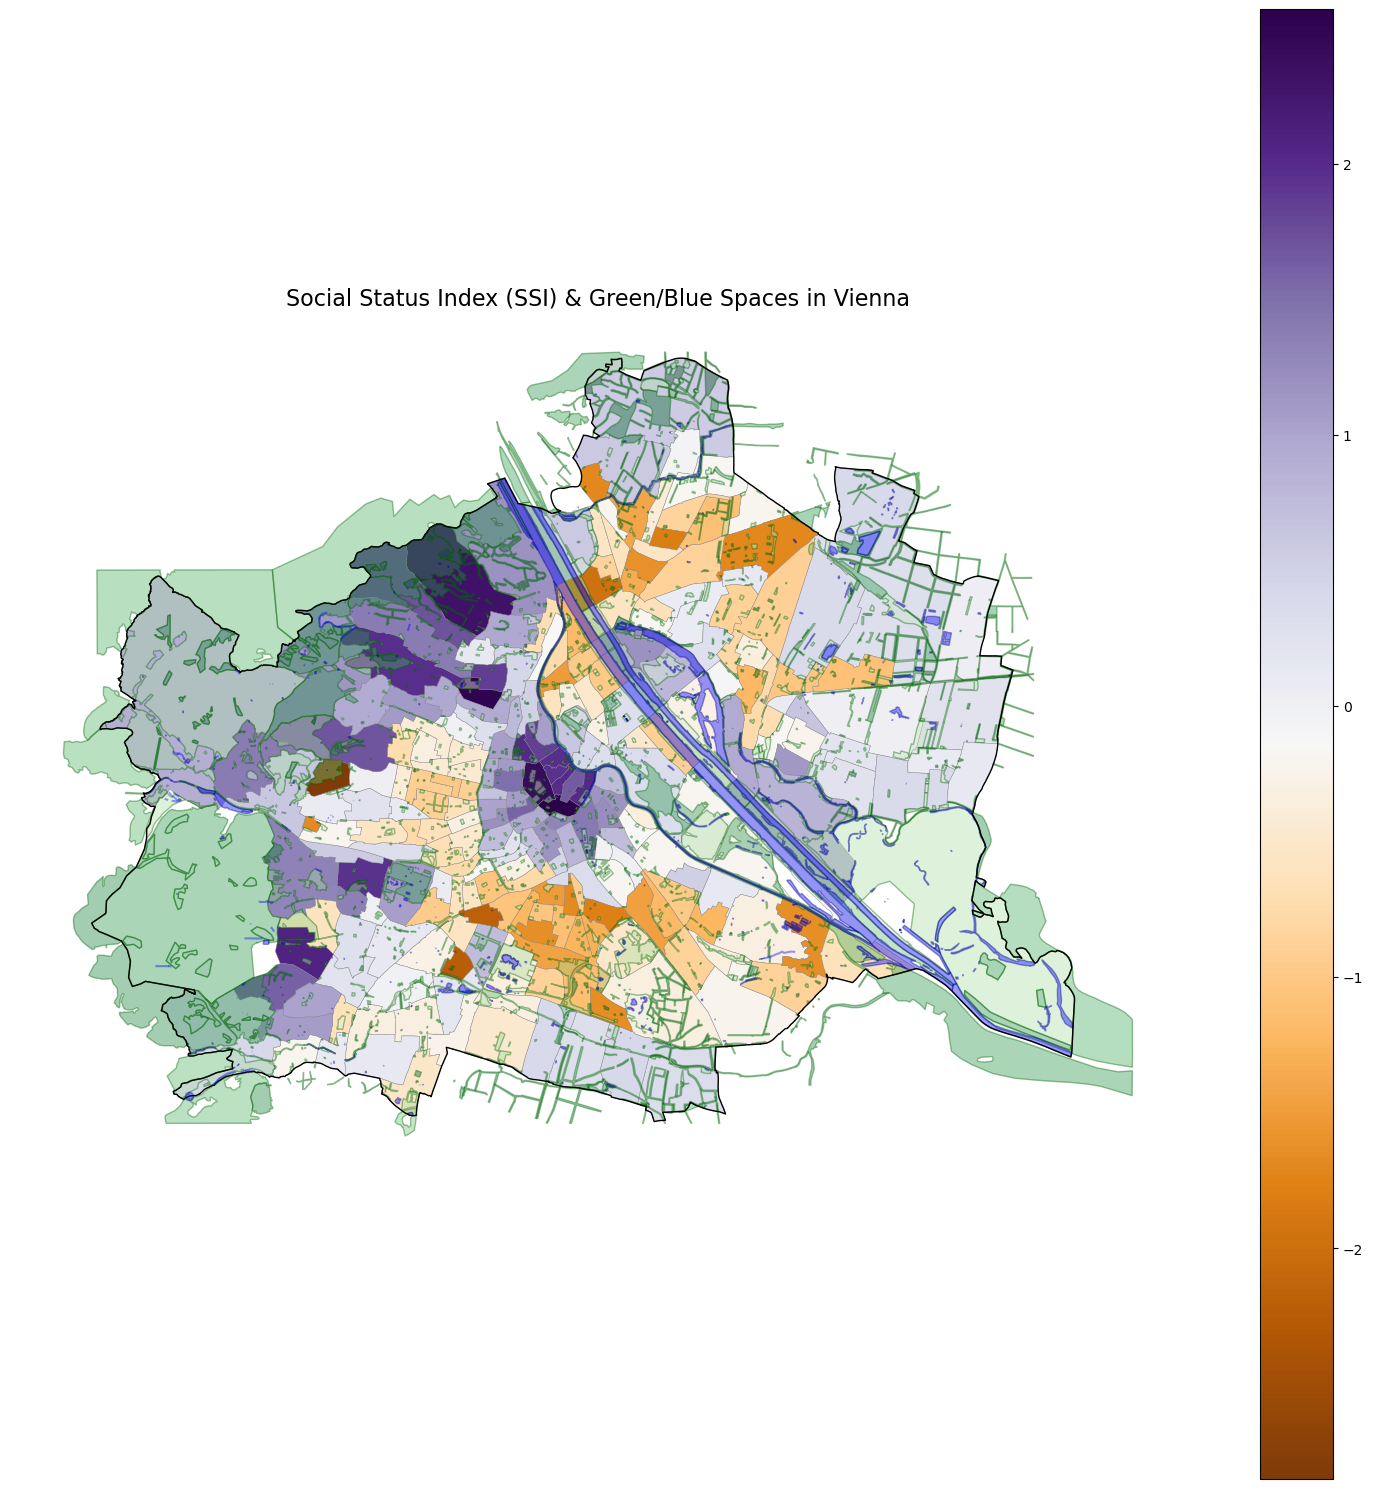

In [20]:
# Plot everything together
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

# Plot SSI as choropleth
gdf_census.plot(
    column='SSI',
    cmap='PuOr',     
    linewidth=0.3,
    edgecolor='gray',
    legend=True,
    ax=ax
)

# Overlay green and blue spaces
gdf_green.plot(ax=ax, cmap='Greens', alpha=0.4, edgecolor='darkgreen') #austrian governmental data
blue_clipped.plot(ax=ax, color='blue', alpha=0.4, edgecolor='darkblue') #OSM data

# Optional: plot city border
admin_city.plot(ax=ax, color='none', edgecolor='black', linewidth=1)

# Tidy up
ax.set_title("Social Status Index (SSI) & Green/Blue Spaces in Vienna", fontsize=16)
ax.axis('off')

plt.tight_layout()

plt.savefig("ssi_ubgs_map.png", dpi=300, bbox_inches='tight')
plt.show()


## Correlation

* How much green/blue space overlap in each census district?
* Does the existence of green/blue spaces correlated with social status index (SSI)?

In [22]:
print(gdf_census.crs)
print(gdf_green.crs)
print(blue.crs)
#print(greens.crs)
print(admin_city.crs)

# epsg 4326 is coordinates, and not good for area and periphery calculations. 
# need to change their crs. Target crs: epsg=31256

gdf_census = gdf_census.to_crs(epsg=31256)
#greens = greens.to_crs(epsg=31256)
gdf_green = gdf_green.to_crs(epsg=31256)
admin_city = admin_city.to_crs(epsg=31256)
blue = blue.to_crs(epsg=31256)


EPSG:4326
EPSG:4326
epsg:4326
epsg:4326


In [23]:
print(gdf_green.geometry.type.unique())
print(blue.geometry.type.unique())

# in order to overlay, I need same types of geometries
# seperate blue geometries into 2 different gdf: blue_lines, blue_areas

# Separate blue space geometries by type
blue_areas = blue[blue.geometry.type.isin(['Polygon', 'MultiPolygon'])].copy()
blue_lines = blue[blue.geometry.type.isin(['LineString', 'MultiLineString'])].copy()

print(blue_areas.geometry.type.unique())
print(blue_lines.geometry.type.unique())

['MultiPolygon' 'Polygon']
['Polygon' 'MultiPolygon' 'LineString']
['Polygon' 'MultiPolygon']
['LineString']


In [24]:
# green areas per district
green_clipped = gpd.clip(gdf_green, admin_city)
green_in_census = gpd.overlay(gdf_census, green_clipped, how='intersection', keep_geom_type=False)
green_in_census['green_area'] = green_in_census.geometry.area
green_area_by_district = green_in_census.groupby('ZBEZ')['green_area'].sum().reset_index()

In [25]:
# blue areas per district
blue_area_in_census = gpd.overlay(gdf_census, blue_areas, how='intersection')
blue_area_in_census['blue_area'] = blue_area_in_census.geometry.area
blue_area_by_district = blue_area_in_census.groupby('ZBEZ')['blue_area'].sum().reset_index()

# blue length per district
blue_lines_in_census = gpd.overlay(gdf_census, blue_lines, how='intersection', keep_geom_type=False)
blue_lines_in_census['blue_length'] = blue_lines_in_census.geometry.length
blue_length_by_district = blue_lines_in_census.groupby('ZBEZ')['blue_length'].sum().reset_index()

In [26]:
# Merge green and blue components into census dataframe
gdf_census = gdf_census.merge(green_area_by_district, on='ZBEZ', how='left')
gdf_census = gdf_census.merge(blue_area_by_district, on='ZBEZ', how='left')
gdf_census = gdf_census.merge(blue_length_by_district, on='ZBEZ', how='left')

# Fill missing values (e.g., no green/blue areas or rivers) with 0
gdf_census[['green_area', 'blue_area', 'blue_length']] = gdf_census[[
    'green_area', 'blue_area', 'blue_length']].fillna(0)

gdf_census

,ZBEZ,university_share,avg_income,unemprate,benefit_share,SSI,quintile,geometry,green_area,blue_area,blue_length
0,0101,1.604954,1.741399,1.125923,1.123008,1.653992,5,"POLYGON ((3485.019 341498.126, 3484.459 341498...",1.176752e+03,16.971625,0.000000
1,0102,1.653812,2.565233,1.237000,1.139440,2.000434,5,"POLYGON ((3487.789 341009.066, 3470.019 341017...",7.766804e+04,34107.715249,0.000000
2,0103,1.706598,3.805033,1.641029,1.232519,2.570582,5,"POLYGON ((2735.149 340257.116, 2743.919 340257...",2.507098e+04,135.225705,0.000000
3,0104,1.845975,3.156000,1.697713,1.313290,2.407460,5,"POLYGON ((2313.839 340611.086, 2356.209 340648...",2.133390e+05,944.004931,0.000000
4,0105,1.681303,2.424953,1.192502,1.252134,1.971322,5,"POLYGON ((2639.529 341630.546, 2697.199 341592...",1.760884e+04,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
241,2315,1.267620,2.076986,1.032159,0.955199,1.604961,5,"POLYGON ((-5057.481 334968.716, -5045.251 3349...",5.373882e+05,947.283495,101.556247
242,2316,-0.038446,0.315260,0.839466,0.834993,0.412143,4,"POLYGON ((-6934.151 335000.496, -6988.981 3349...",4.979837e+06,9551.909724,1240.219551
243,2317,-0.410833,0.503589,0.921774,1.088109,0.406096,4,"POLYGON ((3347.019 334342.706, 3344.129 334343...",1.714858e+05,9746.425345,0.000000
244,2318,-1.138054,-0.177753,-0.123182,0.210761,-0.470587,2,"POLYGON ((631.009 334472.496, 622.769 334473.4...",2.119507e+05,0.000000,0.000000


In [27]:
# Calculate district area in square kilometers (since CRS is in meters)
gdf_census['district_area_km2'] = gdf_census.geometry.area / 1e6

# Normalize each variable by district size
gdf_census['green_ratio'] = gdf_census['green_area'] / gdf_census['district_area_km2']
gdf_census['blue_area_ratio'] = gdf_census['blue_area'] / gdf_census['district_area_km2']
gdf_census['blue_length_km'] = gdf_census['blue_length'] / 1000  # optional, km of river

In [28]:
#COMMENT: DO IT BY EXCLUDING INNERE STADT. IT HAS HIGH SSI, BUT HISTROICAL BUILDINGS LESS UBGS
# Correlation matrix
corr_matrix = gdf_census[['SSI', 'green_ratio', 'blue_area_ratio', 'blue_length_km']].corr()
print(corr_matrix)

                      SSI  green_ratio  blue_area_ratio  blue_length_km
SSI              1.000000     0.204862        -0.054718        0.119803
green_ratio      0.204862     1.000000         0.301759        0.515956
blue_area_ratio -0.054718     0.301759         1.000000       -0.019364
blue_length_km   0.119803     0.515956        -0.019364        1.000000


In [29]:
'''
# to visualize correlations in scatter plots
!pip install seaborn
import seaborn as sns

sns.pairplot(gdf_census[['SSI', 'green_ratio', 'blue_area_ratio', 'blue_length_km']])
plt.show()
'''

"\n# to visualize correlations in scatter plots\n!pip install seaborn\nimport seaborn as sns\n\nsns.pairplot(gdf_census[['SSI', 'green_ratio', 'blue_area_ratio', 'blue_length_km']])\nplt.show()\n"

In [30]:
import statsmodels.api as sm

# Prepare data
X = gdf_census[['university_share', 'avg_income', 'unemprate', 'benefit_share', 'green_ratio', 'blue_area_ratio', 'blue_length_km']]
X = sm.add_constant(X)  # adds intercept term
A = gdf_census[['university_share', 'avg_income', 'unemprate', 'benefit_share']]
A = sm.add_constant(A)  # adds intercept term
B = gdf_census[['green_ratio', 'blue_area_ratio', 'blue_length_km']]
B = sm.add_constant(B)  # adds intercept term
y = gdf_census['SSI']

# Fit model
model = sm.OLS(y, X).fit()
model2 =sm.OLS(y, A).fit()
model3 =sm.OLS(y, B).fit()
print(model.summary())
print(model2.summary())
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:                    SSI   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 9.543e+23
Date:                Tue, 08 Apr 2025   Prob (F-statistic):               0.00
Time:                        12:55:11   Log-Likelihood:                 6009.2
No. Observations:                 246   AIC:                        -1.200e+04
Df Residuals:                     238   BIC:                        -1.197e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             6.752e-12   5.14e-13  

In [31]:
# Prepare data
X = gdf_census['SSI']
X = sm.add_constant(X)  # adds intercept term
y = gdf_census[['green_ratio']]

# Fit model
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            green_ratio   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     10.69
Date:                Tue, 08 Apr 2025   Prob (F-statistic):            0.00123
Time:                        12:55:11   Log-Likelihood:                -3260.6
No. Observations:                 246   AIC:                             6525.
Df Residuals:                     244   BIC:                             6532.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.088e+05   8839.373     12.307      0.0

## Introduction of housing data into the analysis

* Data is from Statistiks Austria. 
* Does the existence of green/blue spaces affect the housing prices in that district?
* If they affect, can we check how it changes with proximity of housing to green/blue space?

In [32]:
!pip install odfpy pandas # because file is .ods file

# Load ODS file and list all sheet names
housing_path = "SpecialEvaluation.ods" 
housing_data = pd.read_excel(housing_path, engine="odf", sheet_name=None)

# Show available sheets
print(housing_data.keys())

dict_keys(['Apartment_Prices', 'House_Prices', 'Building_Plots', 'Federal_Provinces', 'Apartment_Prices_municipalities', 'House_Prices_municipalities', 'Fed__states_and_constr__Periods'])


In [33]:
housing_data = pd.read_excel(
    housing_path,
    engine="odf",
    sheet_name="Apartment_Prices",  
    header=1                        # use row 2 as column names
)
housing_data.columns

Index(['D. CD.', 'Districts', 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022,
       2023],
      dtype='object')

In [34]:
# Keep only Vienna rows
housing_vienna = housing_data[
    housing_data['Districts'].str.contains('Wien', na=False) &
    ~housing_data['Districts'].str.contains('Wiener Neustadt', na=False)
]
housing_vienna.columns = housing_vienna.columns.astype(str)

housing_vienna.loc[:, 'district_clean'] = housing_vienna['Districts'].str.split(',').str[1].str.strip()
housing_vienna

/var/folders/fg/tx5hq3917p5dxc674m9h_4500000gn/T/ipykernel_95022/1985756449.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  housing_vienna.loc[:, 'district_clean'] = housing_vienna['Districts'].str.split(',').str[1].str.strip()


,D. CD.,Districts,2015,2016,2017,2018,2019,2020,2021,2022,2023,district_clean
93,901,"Wien 1.,Innere Stadt",6569,7861,9368,10955,11186,10947,13078,14389,12733,Innere Stadt
94,902,"Wien 2.,Leopoldstadt",3650,4125,4327,4482,4590,5215,5331,6181,5494,Leopoldstadt
95,903,"Wien 3.,Landstraße",3934,4039,4483,4787,4375,5483,5715,5850,5635,Landstraße
96,904,"Wien 4.,Wieden",4189,4237,4932,5195,5650,5586,6471,7776,6646,Wieden
97,905,"Wien 5.,Margareten",3272,3500,3548,3662,3796,4634,5648,5440,4562,Margareten
98,906,"Wien 6.,Mariahilf",4147,4349,4089,4124,4836,5208,5696,5822,5325,Mariahilf
99,907,"Wien 7.,Neubau",4774,4553,4755,5405,5833,6043,6332,6336,5929,Neubau
100,908,"Wien 8.,Josefstadt",4020,4744,5292,4975,4798,5996,7842,7697,6148,Josefstadt
101,909,"Wien 9.,Alsergrund",4106,4132,4942,5215,5250,5321,5734,6234,6017,Alsergrund
102,910,"Wien 10.,Favoriten",2436,3331,3191,3942,3913,3571,3567,4211,3796,Favoriten


In [35]:
districts = gpd.read_file('vienna_districts.geojson') # districts data from GIS course hw2
districts

,NAMEK,BEZNR,BEZ_RZ,NAMEK_NUM,NAMEK_RZ,NAMEG,LABEL,BEZ,DISTRICT_C,STATAUSTRI,STATAUSTR0,FLAECHE,UMFANG,AKT_TIMEST,SE_SDO_ROW,geometry
0,Hietzing,13.0,XIII,"13., Hietzing",XIII. Hietzing,HIETZING,XIII.,13,1130.0,913.0,91301.0,3.771397e+07,29668.16,2023-07-18,13126.0,"POLYGON ((16.21423 48.20652, 16.21425 48.20651..."
1,Rudolfsheim-Fünfhaus,15.0,XV,"15., Rudolfsheim-Fünfhaus",XV. Rudolfsheim-Fünfhaus,RUDOLFSHEIM-FÜNFHAUS,XV.,15,1150.0,915.0,91501.0,3.916953e+06,9711.71,2023-07-18,13127.0,"POLYGON ((16.32732 48.205, 16.33366 48.20406, ..."
2,Neubau,7.0,VII,"7., Neubau",VII. Neubau,NEUBAU,VII.,07,1070.0,907.0,90701.0,1.608248e+06,5312.54,2023-07-18,13128.0,"POLYGON ((16.33873 48.20854, 16.33901 48.20849..."
3,Landstraße,3.0,III,"3., Landstraße",III. Landstraße,LANDSTRASSE,III.,03,1030.0,903.0,90301.0,7.403038e+06,13961.80,2023-07-18,13129.0,"POLYGON ((16.39662 48.20739, 16.39678 48.20656..."
4,Josefstadt,8.0,VIII,"8., Josefstadt",VIII. Josefstadt,JOSEFSTADT,VIII.,08,1080.0,908.0,90801.0,1.089946e+06,4170.30,2023-07-18,13130.0,"POLYGON ((16.34915 48.21516, 16.35099 48.21497..."
5,Innere Stadt,1.0,I,"1., Innere Stadt",I. Innere Stadt,INNERE STADT,I.,01,1010.0,901.0,90101.0,2.868774e+06,6972.75,2023-07-18,13131.0,"POLYGON ((16.37264 48.21662, 16.37314 48.21621..."
6,Ottakring,16.0,XVI,"16., Ottakring",XVI. Ottakring,OTTAKRING,XVI.,16,1160.0,916.0,91601.0,8.673047e+06,18371.12,2023-07-18,13132.0,"POLYGON ((16.27621 48.22704, 16.27646 48.22678..."
7,Alsergrund,9.0,IX,"9., Alsergrund",IX. Alsergrund,ALSERGRUND,IX.,09,1090.0,909.0,90901.0,2.967385e+06,7919.54,2023-07-18,13133.0,"POLYGON ((16.36165 48.23192, 16.36166 48.2319,..."
8,Leopoldstadt,2.0,II,"2., Leopoldstadt",II. Leopoldstadt,LEOPOLDSTADT,II.,02,1020.0,902.0,90201.0,1.924200e+07,27093.08,2023-07-18,13134.0,"POLYGON ((16.40345 48.23192, 16.40503 48.23067..."
9,Währing,18.0,XVIII,"18., Währing",XVIII. Währing,WÄHRING,XVIII.,18,1180.0,918.0,91801.0,6.347205e+06,18058.47,2023-07-18,13135.0,"POLYGON ((16.29502 48.24961, 16.29508 48.2496,..."


In [36]:
# Merging housing prices data into districts GeoDataFrame
housing_districts = districts.merge(
    housing_vienna[['district_clean', '2015', '2016', '2017', '2018', '2019', '2020',  '2021', '2022', '2023']],
    left_on='NAMEK',
    right_on='district_clean',
    how='left'
)

In [37]:
housing_districts.head(3)

,NAMEK,BEZNR,BEZ_RZ,NAMEK_NUM,NAMEK_RZ,NAMEG,LABEL,BEZ,DISTRICT_C,STATAUSTRI,...,district_clean,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Hietzing,13.0,XIII,"13., Hietzing",XIII. Hietzing,HIETZING,XIII.,13,1130.0,913.0,...,Hietzing,4232,4132,4043,4423,4462,4821,5593,6159,5327
1,Rudolfsheim-Fünfhaus,15.0,XV,"15., Rudolfsheim-Fünfhaus",XV. Rudolfsheim-Fünfhaus,RUDOLFSHEIM-FÜNFHAUS,XV.,15,1150.0,915.0,...,Rudolfsheim-Fünfhaus,2429,3369,3315,3827,3860,4111,4729,4460,4215
2,Neubau,7.0,VII,"7., Neubau",VII. Neubau,NEUBAU,VII.,07,1070.0,907.0,...,Neubau,4774,4553,4755,5405,5833,6043,6332,6336,5929


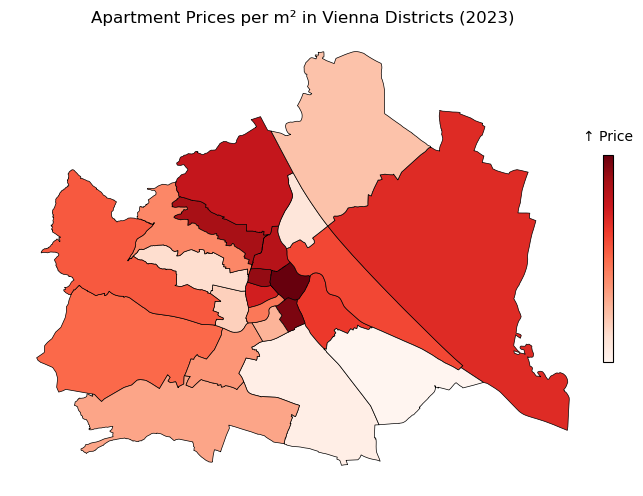

In [38]:
fig, ax = plt.subplots(figsize=(9, 9))

# Plot without legend
housing_districts_plot = housing_districts.plot(
    column='2023',
    cmap='Reds',
    edgecolor='black',
    linewidth=0.5,
    ax=ax,
    legend=False 
)

# Create a scalar mappable for the colorbar
norm = mpl.colors.Normalize(
    vmin=housing_districts['2023'].min(),
    vmax=housing_districts['2023'].max()
)
sm = mpl.cm.ScalarMappable(cmap='Reds', norm=norm)
sm._A = []  # required for matplotlib <3.1

# Adding the colorbar manually
cbar = fig.colorbar(
    sm,
    ax=ax,
    shrink=0.3,              
    pad=0.01,                
    orientation='vertical',
    location='right'         
)

# Remove ticks and add title to the colorbar
cbar.ax.set_yticks([])
cbar.ax.set_title('↑ Price', fontsize=10, pad=10)

# Final plot tweaks
ax.set_title("Apartment Prices per m² in Vienna Districts (2023)", fontsize=12)
ax.axis('off')
plt.show()

In [52]:
green_clipped = green_clipped.to_crs(districts.crs)
blue_clipped = blue_clipped.to_crs(districts.crs)

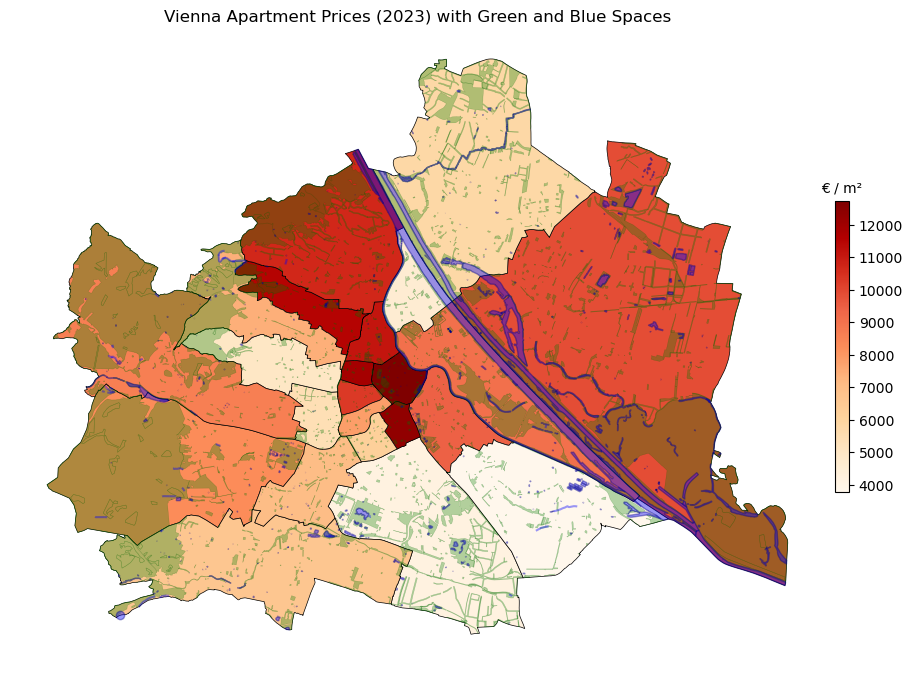

In [54]:
# Setup plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot housing prices as base choropleth
housing_districts.plot(
    column='2023',
    cmap='OrRd',
    edgecolor='black',
    linewidth=0.5,
    ax=ax,
    legend=False  
)

# Overlay green and blue spaces
green_clipped.plot(ax=ax, color='green', alpha=0.3, edgecolor='darkgreen', linewidth=0.3)
blue_clipped.plot(ax=ax, color='blue', alpha=0.4, edgecolor='darkblue')

# Add colorbar manually
norm = mpl.colors.Normalize(vmin=housing_districts['2023'].min(), vmax=housing_districts['2023'].max())
sm = mpl.cm.ScalarMappable(cmap='OrRd', norm=norm)
sm._A = []
cbar = fig.colorbar(sm, ax=ax, shrink=0.3, pad=0.01)
cbar.ax.set_title('€ / m²', fontsize=10)

# Title & layout
ax.set_title("Vienna Apartment Prices (2023) with Green and Blue Spaces", fontsize=12)
ax.axis('off')

plt.tight_layout()
plt.show()


## Correlation of housing prices with UBGS

* Is there a correlation between the amount of green/blue spaces in districts and their average housing price per m2?